#Fake detector
## Adam Paleczny, Mikołaj Słowikowski, Jarosław Skwarczek

In [2]:
!pip install tensorflow-addons -q
!pip install scikit-plot -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.2 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
from sklearn.metrics               import confusion_matrix                              # generate confusion matrix
from sklearn.metrics               import accuracy_score, recall_score, precision_score # performance assessment

In [4]:
import seaborn                as sns    # statistical data visualization
import tensorflow             as tf     # build machine learning models
import scikitplot             as skplt  # data visualization and machine-learning metrics

from tensorflow                    import keras                                         # build deep learning models
from wordcloud                     import WordCloud, STOPWORDS, ImageColorGenerator     # create wordcloud
from sklearn.model_selection       import train_test_split                              # split into training and test sets
from keras.preprocessing.text      import Tokenizer                                     # create tokens
from keras.preprocessing.sequence  import pad_sequences                                 # create padding
from keras.optimizers              import Adam                                          # optimizer for training neural networks
from sklearn.metrics               import confusion_matrix                              # generate confusion matrix
from sklearn.metrics               import accuracy_score, recall_score, precision_score # performance assessment
from sklearn.metrics               import classification_report
from sklearn.linear_model          import LogisticRegression
from keras.models                  import Sequential
from keras.layers                  import Embedding, Dense, LSTM
from keras.preprocessing.sequence  import pad_sequences
from keras.preprocessing.text      import one_hot

In [5]:
DATA = "/content/gdrive/My Drive/Projekt_MIO/dataset_PL/converted-exp-PL.tsv"

In [6]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/')

Mounted at /content/gdrive


## Data

In [ ]:
df = pd.read_csv(DATA,sep='\t')
df.head()

,politicianID,name,party,statementID,statementText,statementState,statementExplanClean,statementExplan
0,1,Paweł Szałamacha,Prawo i Sprawiedliwość,1,"Pamiętamy, że w latach 2006-2007, kiedy rządzi...",TRUE,Według danych Banku Światowego wzrost polskieg...,"<p><span>Według danych </span><a href=""http://..."
1,1,Paweł Szałamacha,Prawo i Sprawiedliwość,2,"Jeżeli patrzymy na dane dla OECD, to Polska je...",TRUE,"Według danych z OECD, Polska znajduje się poni...","<p><span>Według </span><a href=""http://www.oec..."
2,1,Paweł Szałamacha,Prawo i Sprawiedliwość,3,Po kilkuletnim okresie dodatniego przyrostu na...,TRUE,Liczba urodzonych dzieci w Polsce na 1000 mies...,"<p><a href=""http://www.indexmundi.com/g/g.aspx..."
3,1,Paweł Szałamacha,Prawo i Sprawiedliwość,4,Jeszcze dwa dni wcześniej Bank Światowy podwyż...,TRUE,Według danych Banku Światowego zawartych w ana...,<p><span>Według danych Banku Światowego zawart...
4,1,Paweł Szałamacha,Prawo i Sprawiedliwość,5,Jeszcze dzień wcześniej Międzynarodowy Fundusz...,TRUE,W dniu 13 stycznia 2016 r. na stronie Międzyna...,<p><span>W dniu 13 stycznia 2016 r. na stronie...


In [ ]:
df.columns

Index(['politicianID', 'name', 'party', 'statementID', 'statementText',
       'statementState', 'statementExplanClean', 'statementExplan'],
      dtype='object')

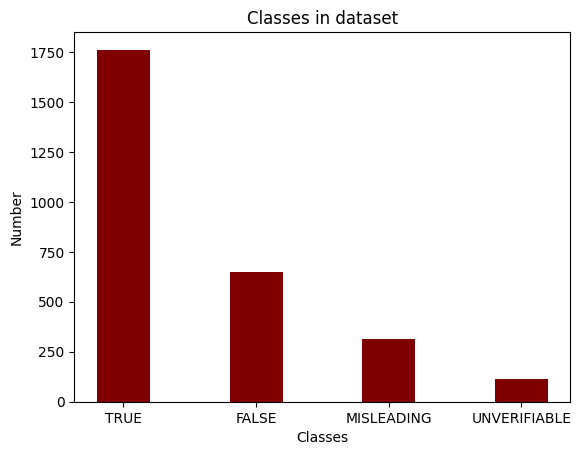

In [ ]:
categories = df['statementState'].value_counts()

plt.bar(categories.index, categories.values, color ='maroon',
        width = 0.4)

plt.xlabel("Classes")
plt.ylabel("Number")
plt.title("Classes in dataset")
plt.show()

In [ ]:
# How many empty labels
df.isnull().sum()

politicianID            0
name                    0
party                   0
statementID             0
statementText           0
statementState          0
statementExplanClean    0
statementExplan         0
dtype: int64

##Prepare for training

In [ ]:
# create the 'clean_text' function that receives the 'text' argument
def clean_text(text):
    # create variable 'word' and divide the text by words and use whitespace as delimiter
    words = str(text).split()

    # convert words to lowercase by adding space to the end of each word
    words = [i.lower() + " " for i in words]

    # join words into a single string, but separated by spaces
    words = " ".join(words)

    # remove punctuation from strings, using the st.punctuation method as an argument
    words = words.translate(words.maketrans('', '', string.punctuation))

    return words

In [ ]:
df['statementText'] = df['statementText'].apply(clean_text)
df['name'] = df['name'].apply(clean_text)
df['party'] = df['party'].apply(clean_text)

In [ ]:
df = df.drop(columns=['politicianID', 'statementID', 'statementExplanClean', 'statementExplan'])

In [ ]:
df['statementState'].value_counts()

statementState
TRUE            1761
FALSE            648
MISLEADING       313
UNVERIFIABLE     113
Name: count, dtype: int64

In [ ]:
train, df_temp = train_test_split(df, test_size=0.25, stratify=df['statementState'], shuffle=True, random_state=123)
validation, test = train_test_split(df, test_size=0.5,stratify=df['statementState'], shuffle=True, random_state=123)
statementStateMap = { "FALSE": 0, "TRUE": 1, "UNVERIFIABLE": 2, "MISLEADING": 3 }

In [ ]:
# converting strings to numbers of test Data
def convertToNumbers(x_data_of_strings, y_data_of_strings, vocab_size, sent_length):
    onehot_rep_train = [one_hot(word, vocab_size) for word in x_data_of_strings]
    ebedded_doc_train = pad_sequences(onehot_rep_train, padding='pre', maxlen = sent_length)
    state_train = np.array(list(map(statementStateMap.get, y_data_of_strings)))
    return ebedded_doc_train, state_train

## Decision Tree Classifier

In [26]:
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

def preprocess_text(text_data):
    preprocessed_text = []

    for sentence in tqdm(text_data):
        sentence = re.sub(r'[^\w\s]', '', sentence)
        preprocessed_text.append(' '.join(token.lower()
                                  for token in str(sentence).split()
                                  if token not in stopwords.words('english')))

    return preprocessed_text


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
preprocessed_review = preprocess_text(df['statementText'].values)
df['statementText'] = preprocessed_review

100%|██████████| 2835/2835 [00:06<00:00, 418.14it/s]


In [ ]:
df['statementText']

0       pamiętamy że w latach 20062007 kiedy rządziło ...
1       jeżeli patrzymy na dane dla oecd polska jest p...
2       po kilkuletnim okresie dodatniego przyrostu na...
3       jeszcze dwa dni wcześniej bank światowy podwyż...
4       jeszcze dzień wcześniej międzynarodowy fundusz...
                              ...                        
2830    przepis wskazujący potrzebne kompetencje zasia...
2831    pis nie robił problemów kiedy trzeba było popr...
2832    dzisiaj w polsce tego badać nie można medyczne...
2833    po badaniach w tej chwili które zostały przepr...
2834    próg referendalny jest 50 nawet jeśli zostanie...
Name: statementText, Length: 2835, dtype: object

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier

# Assuming df is your original DataFrame
statement_to_int = {'TRUE': 1, 'FALSE': 2, 'MISLEADING': 3, 'UNVERIFIABLE': 4}

# Convert the statementState column to integers using the mapping dictionary
df['statementState'] = df['statementState'].map(statement_to_int)

# Split the data
X = df['statementText']
y = df['statementState']
train_statement, test_statement, train_class, test_class = train_test_split(X, y, test_size=0.25, random_state=123)




In [29]:
# Vectorize the text data
vectorization = TfidfVectorizer(strip_accents='ascii')
train_statement_vectorized = vectorization.fit_transform(train_statement)
test_statement_vectorized = vectorization.transform(test_statement)

# Train the model
model = DecisionTreeClassifier()
model.fit(train_statement_vectorized, train_class)

# Evaluate the model (optional)
predictions = model.predict(test_statement_vectorized)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_class, predictions)
print(f'Accuracy: {accuracy}')

ValueError: Input y contains NaN.

In [24]:
import graphviz
from sklearn import tree

# Get feature names from the TfidfVectorizer
feature_names = vectorization.get_feature_names_out()

# Get unique class names from the training labels
class_names = [str(label) for label in sorted(set(train_class))]

# Visualize the model
dot_decision_tree = tree.export_graphviz(model, out_file=None, feature_names=feature_names,
                                         class_names=class_names, filled=True)
decision_tree_plot = graphviz.Source(dot_decision_tree, format='png')
decision_tree_plot.render("decision_tree") # Save the plot as a file
decision_tree_plot # Display the plot


NameError: name 'train_class' is not defined

# Logistic Regression

In [19]:
x_train, x_test, y_train, y_test = train_test_split(df['statementText'],
                                                    df['statementState'],
                                                    test_size=0.25)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)

In [23]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))


0.7121354656632173
0.6191819464033851


# Bidirectional LSTM model

In [7]:
df = pd.read_csv(DATA,sep='\t')
df = df.drop(columns=['politicianID', 'statementID', 'statementExplanClean', 'statementExplan'])

In [8]:
voc_size=10000
embedding_vector_features=40
sent_length = 500

In [10]:
train, df_temp = train_test_split(df, test_size=0.25, stratify=df['statementState'], shuffle=True, random_state=123)
validation, test = train_test_split(df, test_size=0.5,stratify=df['statementState'], shuffle=True, random_state=123)

In [11]:
from keras.utils import to_categorical
# Define the mapping from class names to numbers (0 to 3)
statementStateMap = {'TRUE': 0, 'FALSE': 1, 'MISLEADING': 2, 'UNVERIFIABLE': 3}

# Define the function to convert strings to numbers
def convertToNumbers2(x_data_of_strings, y_data_of_strings, vocab_size, sent_length):
    onehot_rep_train = [one_hot(word, vocab_size) for word in x_data_of_strings]
    ebedded_doc_train = pad_sequences(onehot_rep_train, padding='pre', maxlen=sent_length)
    state_train = np.array(list(map(statementStateMap.get, y_data_of_strings)))
    return ebedded_doc_train, state_train


# Assuming 'train' and 'validation' are your DataFrames
X_train, Y_train = convertToNumbers2(train['statementText'], train['statementState'], voc_size, sent_length)
X_test, Y_test = convertToNumbers2(validation['statementText'], validation['statementState'], voc_size, sent_length)

# Now X_train, Y_train, X_test, and Y_test are ready to be used in your model

Y_train = to_categorical(Y_train, num_classes=4)
Y_test = to_categorical(Y_test, num_classes=4)

In [ ]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout

#Setting up vocabulary size
model1 = Sequential()
model1.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model1.add(Bidirectional(LSTM(100)))  # Bidirectional LSTM layer
model1.add(Dropout(0.3))
model1.add(Dense(4, activation='softmax'))  # Use softmax for multi-class classification
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Use categorical crossentropy
print(model1.summary())

# Train the model
model1.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=64)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 40)           400000    
                                                                 
 bidirectional (Bidirection  (None, 200)               112800    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 4)                 804       
                                                                 
Total params: 513604 (1.96 MB)
Trainable params: 513604 (1.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
34/34 [==============================] - 67s 2s/step - loss: 1.1192 - 

In [ ]:
pred = model1.predict(X_test)

45/45 [==============================] - 8s 169ms/step


In [ ]:
pred

array([[9.9144804e-01, 4.4784164e-03, 2.0056642e-03, 2.0677221e-03],
       [9.9731493e-01, 1.0206491e-03, 1.3496352e-03, 3.1483360e-04],
       [9.9848998e-01, 1.0315775e-03, 2.9105428e-04, 1.8718312e-04],
       ...,
       [9.9863154e-01, 7.6135615e-04, 4.2214186e-04, 1.8497284e-04],
       [9.3699402e-01, 4.8143130e-02, 7.8747645e-03, 6.9880746e-03],
       [5.0487015e-03, 4.4101425e-02, 2.0105213e-01, 7.4979770e-01]],
      dtype=float32)

In [ ]:
# Convert predicted probabilities to class labels
pred_class = np.argmax(pred, axis=1)

# If Y_test is one-hot encoded, convert it back to class labels
Y_test_class = np.argmax(Y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(Y_test_class, pred_class)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 99.15%


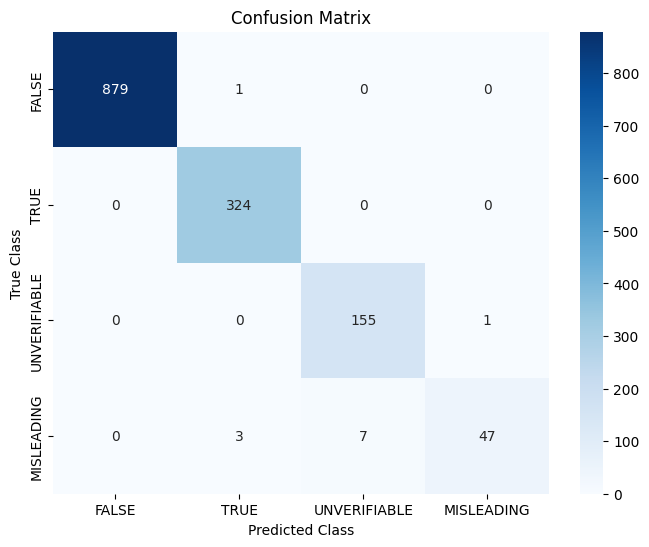

In [ ]:
conf_matrix = confusion_matrix(Y_test_class, pred_class)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["FALSE", "TRUE", "UNVERIFIABLE", "MISLEADING"], yticklabels=["FALSE", "TRUE", "UNVERIFIABLE", "MISLEADING"])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

# LSTM

In [14]:
# some constants

X_train, Y_train = convertToNumbers2(train['statementText'], train['statementState'], voc_size, sent_length)
X_test, Y_test = convertToNumbers2(validation['statementText'], validation['statementState'], voc_size, sent_length)

Y_train = to_categorical(Y_train, num_classes=4)
Y_test = to_categorical(Y_test, num_classes=4)

model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length = sent_length))
model.add(LSTM(100))
# In Keras, LSTM layer LSTM(100), the number 100 represents the number of units or neurons in the LSTM layer.
model.add(Dense(4, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics=['accuracy'])
print(model.summary())

model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 10 , batch_size=64)

y_pred = np.where(model.predict(X_test) > 0.5, 1,0)
print(np.sum(y_pred) / y_pred.shape[0])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 40)           400000    
                                                                 
 lstm_1 (LSTM)               (None, 100)               56400     
                                                                 
 dense_1 (Dense)             (None, 4)                 404       
                                                                 
Total params: 456804 (1.74 MB)
Trainable params: 456804 (1.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
34/34 [==============================] - 34s 856ms/step - loss: 0.5139 - accuracy: 0.6082 - val_loss: 0.4294 - val_accuracy: 0.6210
Epoch 2/10
34/34 [==============================] - 33s 968ms/step - loss: 0.4311 - accuracy: 0.6209 - val_loss: 0.4275 - val_accuracy

# Save weights

In [ ]:
# Save the model weights
model1.save_weights('/content/gdrive/My Drive/Projekt_MIO/model_weights.h5')
print("Model weights saved to model_weights.h5")

Model weights saved to model_weights.h5
